In [4]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob
     
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
train_path = 'C:/Users/drago/Tank_data/train'
test_path = 'C:/Users/drago/Tank_data/test'

Challenger2_dir = '/Challenger2/'
K2_dir = '/K2/'
Leopard2_dir = '/Leopard2/'

In [6]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), # 이미지 resize
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

In [7]:
#batchSize
batchSize=32

In [8]:
#dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=0)

In [9]:
print(trainset[0][0].shape)
print(trainset[0][0])

torch.Size([3, 256, 256])
tensor([[[0.7686, 0.7725, 0.7569,  ..., 0.6471, 0.6157, 0.5922],
         [0.7725, 0.7490, 0.7059,  ..., 0.6471, 0.6157, 0.5961],
         [0.6824, 0.6392, 0.5804,  ..., 0.6431, 0.6157, 0.6000],
         ...,
         [0.2039, 0.2000, 0.1961,  ..., 0.4549, 0.3882, 0.3098],
         [0.1922, 0.1882, 0.1804,  ..., 0.4980, 0.4078, 0.3216],
         [0.0627, 0.0588, 0.0510,  ..., 0.5059, 0.4078, 0.3490]],

        [[0.6392, 0.6431, 0.6275,  ..., 0.4824, 0.4745, 0.4627],
         [0.6431, 0.6196, 0.5765,  ..., 0.4863, 0.4784, 0.4667],
         [0.5529, 0.5098, 0.4471,  ..., 0.4824, 0.4784, 0.4745],
         ...,
         [0.3490, 0.3451, 0.3412,  ..., 0.5961, 0.5294, 0.4510],
         [0.2941, 0.2902, 0.2824,  ..., 0.6431, 0.5529, 0.4706],
         [0.1294, 0.1255, 0.1176,  ..., 0.6510, 0.5608, 0.5020]],

        [[0.4314, 0.4431, 0.4275,  ..., 0.1843, 0.1686, 0.1529],
         [0.4431, 0.4196, 0.3765,  ..., 0.1765, 0.1608, 0.1490],
         [0.3529, 0.3098, 0.2588

In [26]:
'''FPN in PyTorch.

See the paper "Feature Pyramid Networks for Object Detection" for more details.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class FPN(nn.Module):
    def __init__(self, block, num_blocks,num_classes):
        super(FPN, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        # Bottom-up layers
        self.layer1 = self._make_layer(block,  32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        # Top layer
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)  # #output channel -> 256,

        # Smooth layers

        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        #다 256 채널 깊이로 만들어줌 , 1x1 conv
        # Lateral layers
        self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.

        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.

        Returns:
          (Variable) added feature map.

        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.

        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]

        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        # Bottom-up
        c1 = F.relu(self.bn1(self.conv1(x)))
        c1 = F.max_pool2d(c1, kernel_size=3, stride=2, padding=1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        # Top-down
        p5 = self.toplayer(c5) #top layer 1by1 conv
        p4 = self._upsample_add(p5, self.latlayer1(c4)) #채널 조정해준 뒤 upsampling 두번째 위에꺼 그리고 merge
        p3 = self._upsample_add(p4, self.latlayer2(c3)) #채널 조정해준 뒤 upsampling 세번째 위에꺼 그리고 merge
        p2 = self._upsample_add(p3, self.latlayer3(c2)) #채널 조정해준 뒤 upsampling 맨 밑에꺼 그리고 merge
        # Smooth

        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)

        x = self.avgpool(p2)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x


def FPN_Net():

    return FPN(Bottleneck, [3,4,6,3],3).to(device)

"""
def test():
    net = FPN_Net()
    fms = net(Variable(torch.randn(1,3,600,900)))
    for fm in fms:
        print(fm.size())

test()
"""


'\ndef test():\n    net = FPN_Net()\n    fms = net(Variable(torch.randn(1,3,600,900)))\n    for fm in fms:\n        print(fm.size())\n\ntest()\n'

In [27]:
model = FPN_Net()

In [28]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256), device=device)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,704
├─BatchNorm2d: 1-2                       64
├─Sequential: 1-3                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  1,024
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Conv2d: 3-5                  4,096
|    |    └─BatchNorm2d: 3-6             256
|    |    └─Sequential: 3-7              4,352
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-8                  4,096
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Conv2d: 3-10                 9,216
|    |    └─BatchNorm2d: 3-11            64
|    |    └─Conv2d: 3-12                 4,096
|    |    └─BatchNorm2d: 3-13            256
|    |    └─Sequential: 3-14             --
|    └─Bottleneck: 2-3                   --
|    |    └─Conv2d: 3-15                 4,09

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,704
├─BatchNorm2d: 1-2                       64
├─Sequential: 1-3                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  1,024
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Conv2d: 3-5                  4,096
|    |    └─BatchNorm2d: 3-6             256
|    |    └─Sequential: 3-7              4,352
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-8                  4,096
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Conv2d: 3-10                 9,216
|    |    └─BatchNorm2d: 3-11            64
|    |    └─Conv2d: 3-12                 4,096
|    |    └─BatchNorm2d: 3-13            256
|    |    └─Sequential: 3-14             --
|    └─Bottleneck: 2-3                   --
|    |    └─Conv2d: 3-15                 4,09

In [29]:
import torch.optim as optim

"""
lr = 0.0008

optimizer = 'Adam'
"""

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [30]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [31]:
epochs = 100

In [32]:
train_loss=[]
test_accuracy=[]

for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    for i, (images, labels) in enumerate (trainloader,0):
        images=images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
                                                                                                            # predict classes using images from the training set
        outputs = model(images)
        loss = criterion(outputs, labels)
                                                                                                                                                            # backpropagate the loss
        loss.backward()
        optimizer.step()

                                                                                                                                                                                                               # Let's print statistics for every 1,000 images
        running_loss += loss.item()     # extract the loss value

    train_loss.append(running_loss)

    print('[%d, %5d] loss: %.3f' %(epoch + 1, epochs, running_loss ))

    model.eval()
    accuracy = 0.0
    total = 0.0


    with torch.no_grad():
        for i, (images, labels) in enumerate (testloader,0):

            images=images.to(device)
            labels = labels.to(device)
            outputs = model(images)
              # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    test_accuracy.append(accuracy)
    print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))



C:\Users\drago\anaconda3\envs\object_detection\lib\site-packages\torch\nn\functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


[1,   100] loss: 70.367
For epoch 1 the test accuracy over the whole test set is 33 %
[2,   100] loss: 70.335
For epoch 2 the test accuracy over the whole test set is 33 %
[3,   100] loss: 70.303
For epoch 3 the test accuracy over the whole test set is 33 %
[4,   100] loss: 70.293
For epoch 4 the test accuracy over the whole test set is 33 %
[5,   100] loss: 70.276
For epoch 5 the test accuracy over the whole test set is 35 %
[6,   100] loss: 70.221
For epoch 6 the test accuracy over the whole test set is 36 %
[7,   100] loss: 70.255
For epoch 7 the test accuracy over the whole test set is 33 %
[8,   100] loss: 70.194
For epoch 8 the test accuracy over the whole test set is 37 %
[9,   100] loss: 70.175
For epoch 9 the test accuracy over the whole test set is 30 %
[10,   100] loss: 70.138
For epoch 10 the test accuracy over the whole test set is 34 %
[11,   100] loss: 70.096
For epoch 11 the test accuracy over the whole test set is 36 %
[12,   100] loss: 70.117
For epoch 12 the test acc

[95,   100] loss: 68.390
For epoch 95 the test accuracy over the whole test set is 40 %
[96,   100] loss: 68.376
For epoch 96 the test accuracy over the whole test set is 40 %
[97,   100] loss: 68.224
For epoch 97 the test accuracy over the whole test set is 39 %
[98,   100] loss: 67.888
For epoch 98 the test accuracy over the whole test set is 43 %
[99,   100] loss: 68.477
For epoch 99 the test accuracy over the whole test set is 36 %
[100,   100] loss: 67.835
For epoch 100 the test accuracy over the whole test set is 35 %


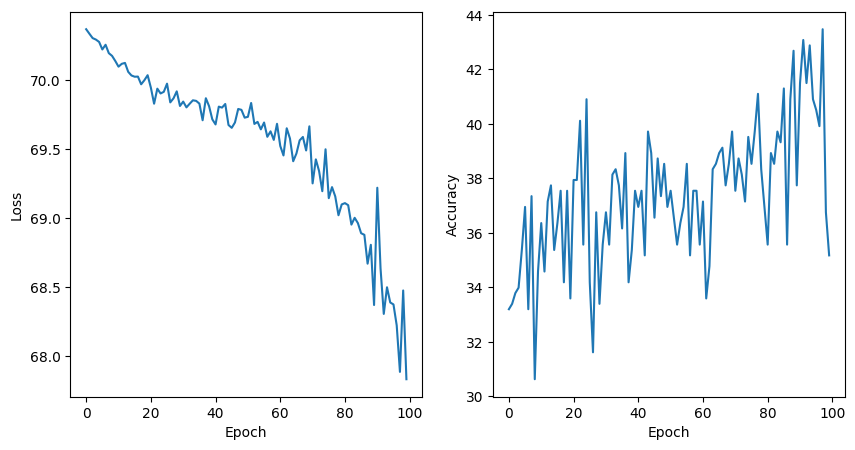

"\nnp.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_train_loss_100',train_loss)\nnp.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_test_accuracy_100',test_accuracy)\n"

In [33]:
import numpy as np
import matplotlib.pyplot as plt

_epochs = np.arange(0,epochs)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(_epochs,train_loss)
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(_epochs, test_accuracy)
plt.show()

train_loss=np.array(train_loss)
test_accuracy=np.array(test_accuracy)

"""
np.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_train_loss_100',train_loss)
np.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_test_accuracy_100',test_accuracy)
"""

In [ ]:
np.save('C:/Users/drago/Learning_result/FPN_train_loss_100',train_loss)
np.save('C:/Users/drago/Learning_result/FPN_test_accuracy_100',test_accuracy)